# Telco Customer Churn

<p style='text-align: justify;'>
Customer churn is a major problem for many industries. Customer churn happens when customers decide to not continue purchasing products or services from an organization and end their association. It is an integral parameter for all the organizations since losing customers requires gaining new customers to replace them, and acquiring a new customer could cost almost 10 times more than retaining an existing one. Therefore, customer churn can prove to be a roadblock for an exponentially growing organization and a retention strategy should be decided in order to avoid an increase in customer churn rates.
</p>

Our goal is to identify some patterns between churned customers and see if we can successfully detect and prevent churn using Machine Learning.

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Notebook Settings*](#notebook_settings)
    - [*1.3. Data Collection*](#data_collection)
- [*2. Data Cleansing*](#data_cleansing)
    - [*2.1. Target Variable*](#target_variable)
    - [*2.2. Data Features*](#data_features)
- [*3. Exploratory Data Analysis*](#eda)
    - [*3.1. Target Variable Distribution*](#target_variable_distribution)
    - [*3.2. Feature Distributions (vs Target Variable)*](#feature_distributions)
- [*4. Data Preprocessing*](#data_preprocessing)
    - [*4.1. One-Hot Encoding*](#ohe)
    - [*4.2. Train Test Split*](#train_test_split)
- [*5. Feature Engineering*](#feature_engineering)
    - [*5.1. Feature Transformation*](#feature_transformation)
    - [*5.2. Feature Scaling*](#feature_scaling)
    - [*5.3. Handle Class Imbalance*](#handle_class_imbalance)
- [*6. Modeling*](#modeling)
    - [*6.1. Cross Validation*](#cross_validation)
    - [*6.2. GridSearchCV*](#grid_search_cv)
    - [*6.3. Predictions (on test set)*](#predictions)
    - [*6.4. Feature Importance*](#feature_importance)

---

## Introduction <a class='anchor' id='introduction'></a>

### *Libraries* <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

import scipy.stats.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import shapiro, boxcox

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from functions.handle_class_imbalance import *
from functions.modeling import *

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

### *Notebook Settings* <a class='anchor' id='notebook_settings'></a>

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### *Data Collection* <a class='anchor' id='data_collection'></a>

- The dataset was acquired from [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn)

##### *Read the data*

In [3]:
df = pd.read_csv('./data/telco_customer_churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleansing <a class='anchor' id='data_cleansing'></a>

- Before we proceed with the next steps, we need first to clean our data

### *Target Variable* <a class='anchor' id='target_variable'></a>

- Our target variable is the column `Churn`
- As we see, the values in this column are in `object` format
- We will convert these values to numeric

##### *Convert target variable to numerical*

In [7]:
df['Churn'] = df['Churn'].apply(lambda x: 0 if x.strip().lower() == 'no' else 1)

### *Data Features* <a class='anchor' id='data_features'></a>

- The column `TotalCharges`, contains the amount of total charges per customer in euros (€)
- However, even though it contains numerical data, they appear as `object` type
- Therefore, we will change the type of this column and convert its values to numeric

##### *Convert `TotalCharges` to numerical*

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce', downcast='float')

##### *Check for any nan values*

In [9]:
df.TotalCharges.isna().sum()

11

##### *Let's investigate these 11 records*

In [10]:
df[df.TotalCharges.isna()][['customerID','tenure','Contract','MonthlyCharges','TotalCharges','Churn']]

,customerID,tenure,Contract,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,0,Two year,52.55,NaN,0
753,3115-CZMZD,0,Two year,20.25,NaN,0
936,5709-LVOEQ,0,Two year,80.85,NaN,0
1082,4367-NUYAO,0,Two year,25.75,NaN,0
1340,1371-DWPAZ,0,Two year,56.05,NaN,0
3331,7644-OMVMY,0,Two year,19.85,NaN,0
3826,3213-VVOLG,0,Two year,25.35,NaN,0
4380,2520-SGTTA,0,Two year,20.00,NaN,0
5218,2923-ARZLG,0,One year,19.70,NaN,0
6670,4075-WKNIU,0,Two year,73.35,NaN,0


- It seems that these 11 customers are new customers who have not yet completed their first month (`tenure = 0`)
- Therefore, we don't know how they will behave at the end of their first month
- Since we don't know what they will do in the future, and given the fact that they are very few, we will drop these records

##### *Drop those 11 nan values*

In [11]:
df = df.dropna(subset=['TotalCharges'])

##### *Handle `PaymentMethod` column*

In [12]:
df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

- As we see, some of the payment methods are characterized as *automatic*
- Therefore, we will create a new binary feature to distinguish between automatic and non-automatic payment methods

##### *Create new binary feature for automatic payment methods*

In [13]:
# create the new binary feature
df['auto_PaymentMethod'] = df['PaymentMethod'].apply(lambda x: 0 if 'automatic' not in x.strip().lower() else 1)

# remove the text "(automatic)" from the initial column
df['PaymentMethod'] = df['PaymentMethod'].apply(lambda x: x.split(' (')[0])

In [14]:
df.PaymentMethod.value_counts()

Electronic check    2365
Mailed check        1604
Bank transfer       1542
Credit card         1521
Name: PaymentMethod, dtype: int64

In [15]:
df.auto_PaymentMethod.value_counts()

0    3969
1    3063
Name: auto_PaymentMethod, dtype: int64

In [16]:
df[['PaymentMethod', 'auto_PaymentMethod']].head()

,PaymentMethod,auto_PaymentMethod
0,Electronic check,0
1,Mailed check,0
2,Mailed check,0
3,Bank transfer,1
4,Electronic check,0


##### *Handle `InternetService` column*

In [17]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

- The `InternetService` column contains information about the type of Internet service provided to each customer
- We will parse this information into 3 separate binary columns, like we did with `auto_PaymentMethod` above

##### *Create binary features for the services provided to each customer*

In [18]:
# internet service (in general)
df['InternetService_yn'] = df['InternetService'].apply(lambda x: 0 if x.strip().lower() == 'no' else 1)

# DSL internet service
df['DSL_yn'] = df['InternetService'].apply(lambda x: 1 if x.strip().lower() == 'dsl' else 0)

# Fiber optic internet service
df['Fiber_yn'] = df['InternetService'].apply(lambda x: 1 if x.strip().lower() == 'fiber optic' else 0)

In [19]:
df[['InternetService', 'InternetService_yn', 'DSL_yn', 'Fiber_yn']].iloc[70:80]

,InternetService,InternetService_yn,DSL_yn,Fiber_yn
70,DSL,1,1,0
71,No,0,0,0
72,Fiber optic,1,0,1
73,No,0,0,0
74,DSL,1,1,0
75,Fiber optic,1,0,1
76,DSL,1,1,0
77,DSL,1,1,0
78,DSL,1,1,0
79,No,0,0,0


##### *Handle the rest of the columns*

In [20]:
rest = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in rest:
    print(f'{col}')
    print(f'{df[col].value_counts()}', end='\n\n')

MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64

OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64

DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64

TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64

StreamingTV
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64

StreamingMovies
No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64



- There are already columns containing information for whether a customer has a phone service and/or an internet service
- Therefore, for the columns above, we will create new binary features for whether a customer has any of the folllowing services

    
##### *Create binary features for the rest of the services*

In [21]:
for col in rest:
    df[f'{col}_yn'] = df[col].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0)

In [22]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.850000,0,0,1,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.500000,0,0,1,1,0,0,1,0,1,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002,1,0,1,1,0,0,1,1,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.750000,0,1,1,1,0,0,1,0,1,1,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994,1,0,1,0,1,0,0,0,0,0,0,0


## EDA <a class='anchor' id='eda'></a>

- In this section, we analyze the data using visual techniques
- Specifically, we will try to understand the relationship between different features and our target variable
- We will look for trends, patterns and common characteristics between customers to find interesting insights

### *Target Variable Distribution* <a class='anchor' id='target_variable_distribution'></a>

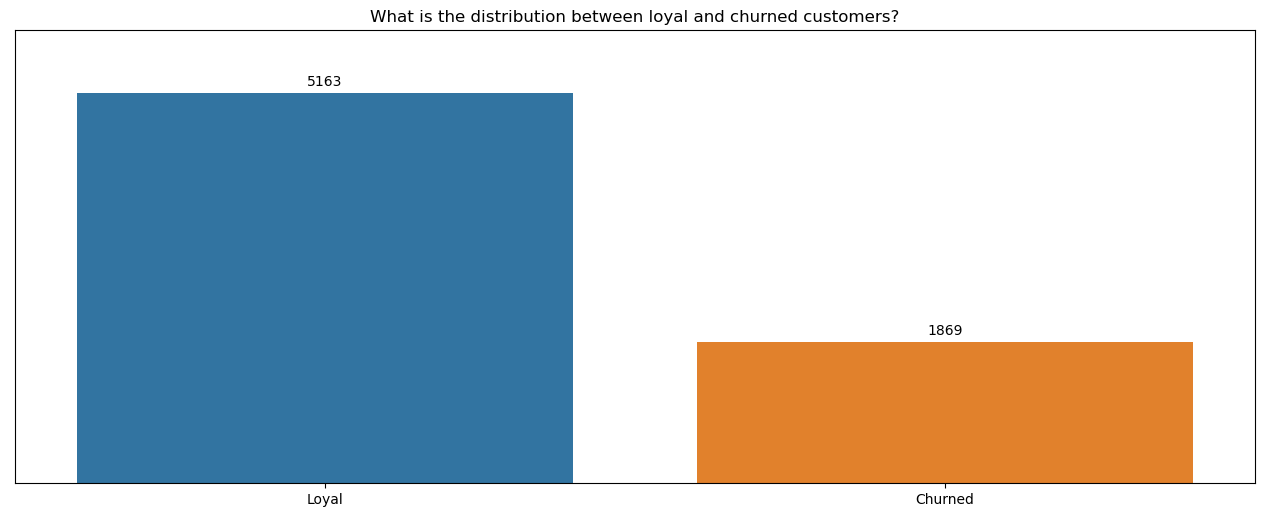

				 26.6% of the customers churned within the last month.


In [23]:
# create figure
plt.figure(figsize=(16,6), dpi=100, facecolor='white')

# plot
ax = sns.countplot(data=df, x=df.Churn)
ax.bar_label(ax.containers[0], padding=3)
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0,6000)
plt.xticks(ticks=[0,1], labels=['Loyal', 'Churned'])
plt.yticks([])
plt.title('What is the distribution between loyal and churned customers?')
plt.savefig('./images/class_distribution.svg')
plt.savefig('./images/class_distribution.jpg')
plt.show()

print(f'\t\t\t\t {df.Churn.sum() / len(df) * 100:.3}% of the customers churned within the last month.')

- According to the graph, approx. 1 out of 4 customers left the company within the last month

### *Feature Distributions (vs Target Variable)* <a class='anchor' id='feature_distributions'></a>

##### *Plot demographics*

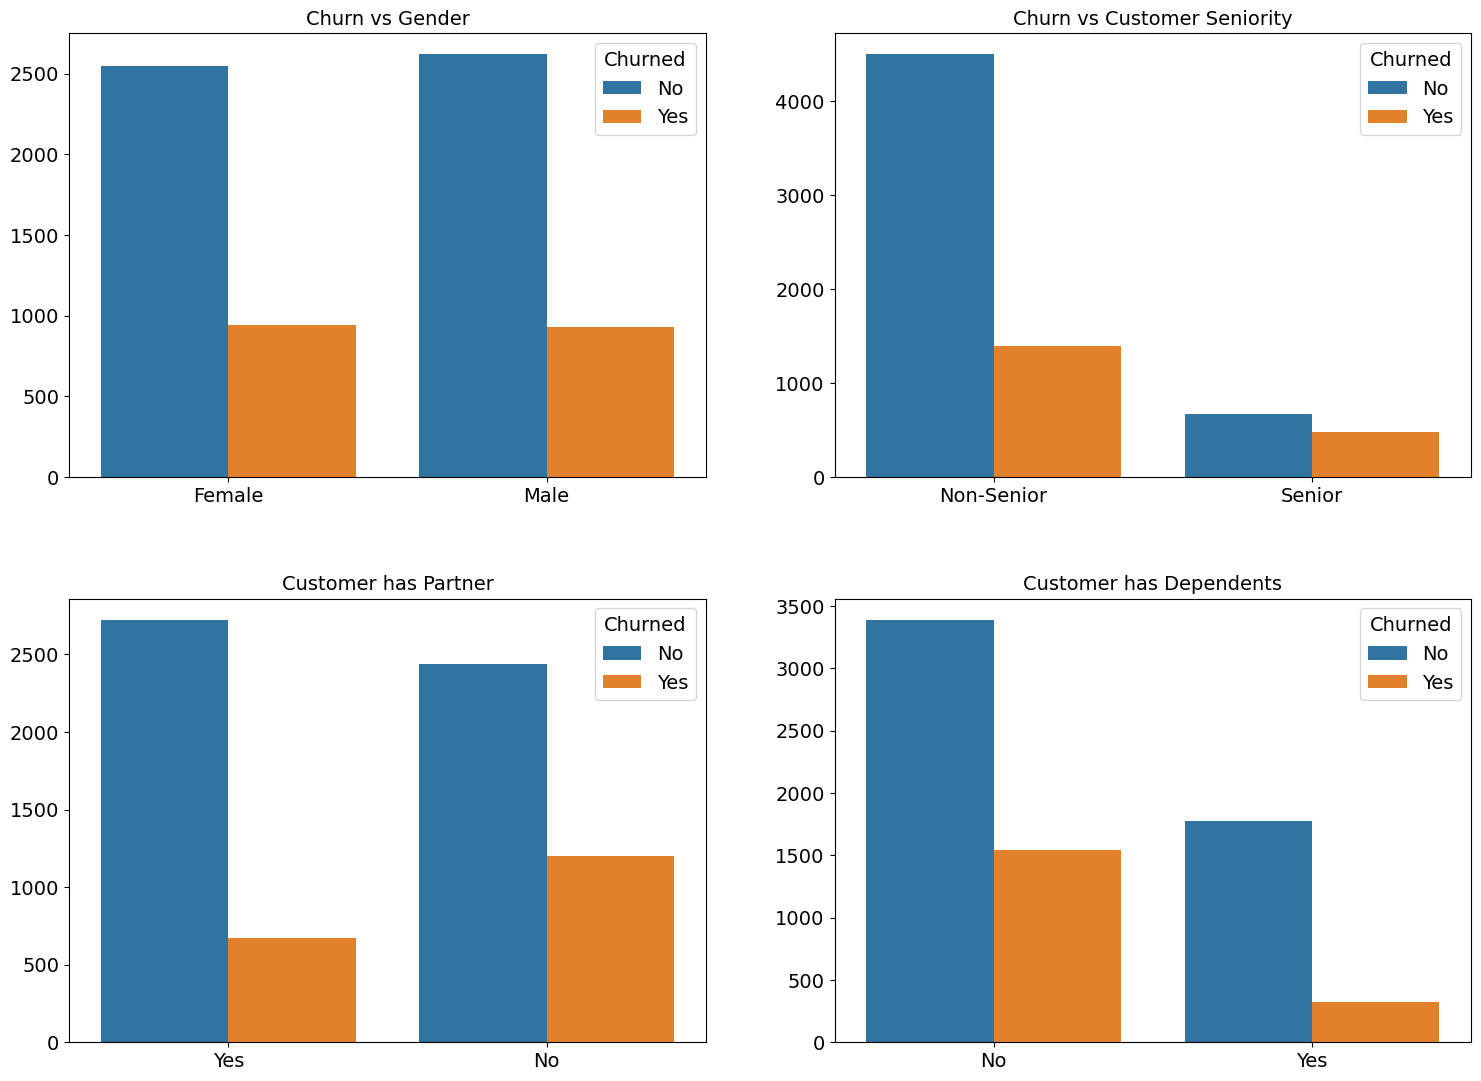

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16,12), dpi=100, facecolor='white')

sns.countplot(x='gender', hue='Churn', data=df, ax=ax[0,0])
ax[0,0].set_xlabel(None)
ax[0,0].set_ylabel(None)
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,0].set_title('Churn vs Gender', fontsize=14)

sns.countplot(x=df['SeniorCitizen'], hue='Churn', data=df, ax=ax[0,1])
ax[0,1].set_xlabel(None)
ax[0,1].set_ylabel(None)
ax[0,1].set_xticklabels(['Non-Senior', 'Senior'], fontsize=14)
ax[0,1].tick_params(axis='y', which='major', labelsize=14)
ax[0,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,1].set_title('Churn vs Customer Seniority', fontsize=14)

sns.countplot(x='Partner', hue='Churn', data=df, ax=ax[1,0])
ax[1,0].set_xlabel(None)
ax[1,0].set_ylabel(None)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,0].set_title('Customer has Partner', fontsize=14)

sns.countplot(x='Dependents', hue='Churn', data=df, ax=ax[1,1])
ax[1,1].set_xlabel(None)
ax[1,1].set_ylabel(None)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,1].set_title('Customer has Dependents', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/demographics.svg')
fig.show()

- According to the graphs, churn is not a matter of gender
- However, senior citizens and customers with partners or dependents are more likely to churn

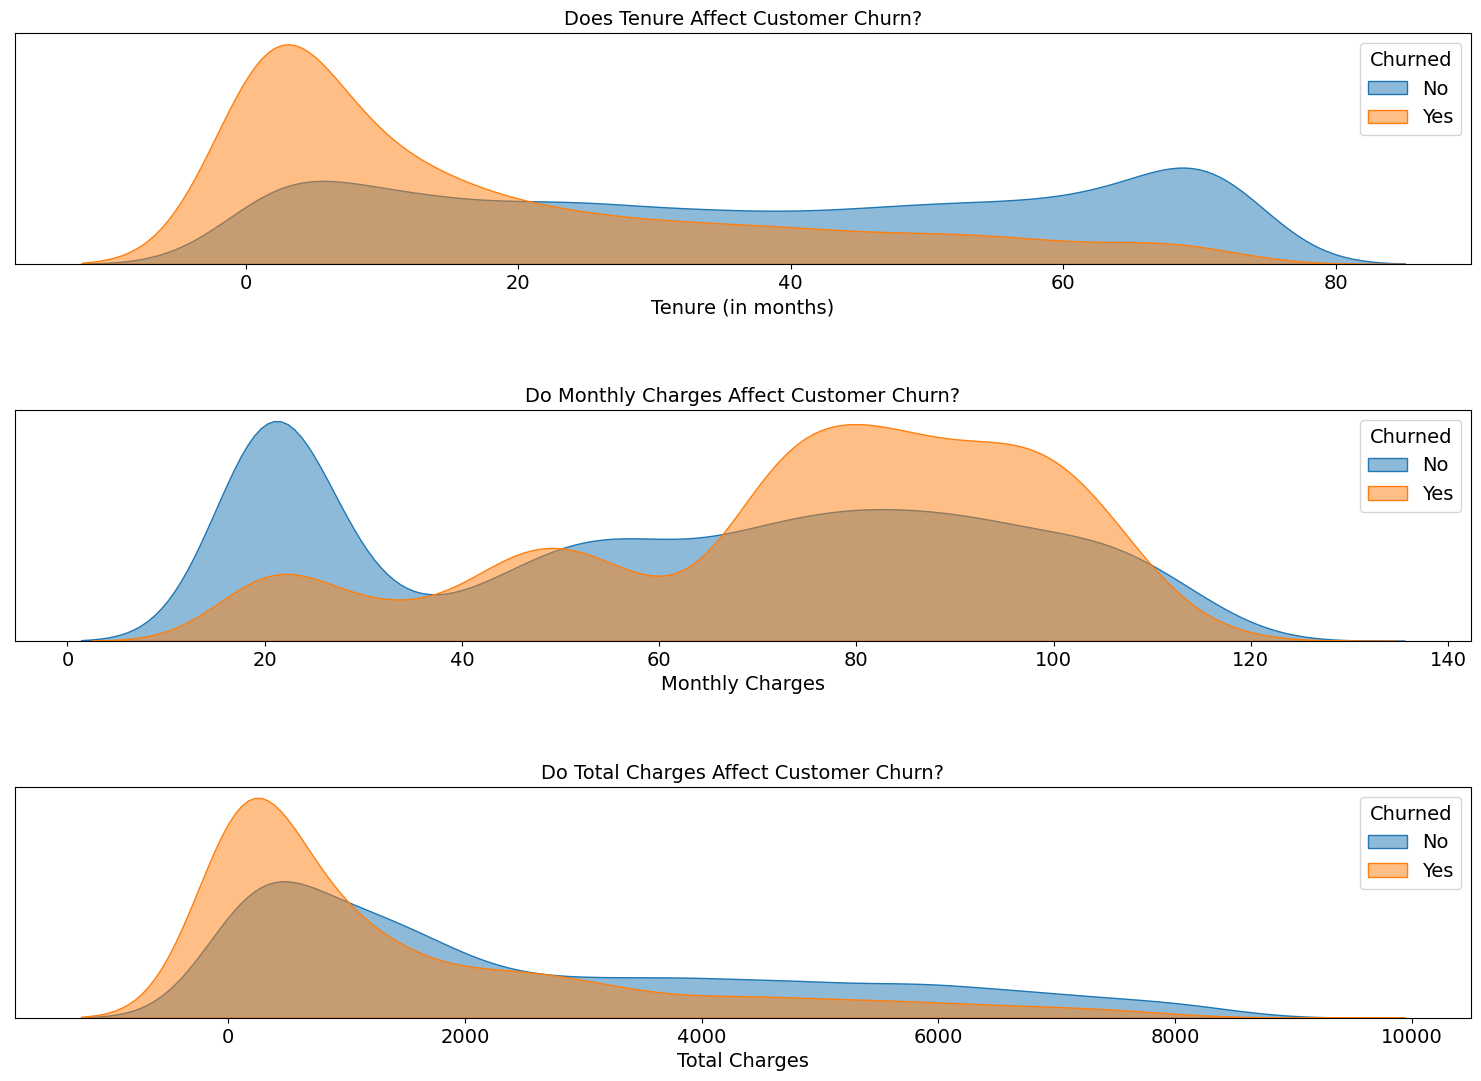

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(16,12), dpi=100, facecolor='white')

sns.kdeplot(df[df['Churn'] == 0]['tenure'], shade=True, alpha=0.5, label='No', ax=ax[0])
sns.kdeplot(df[df['Churn'] == 1]['tenure'], shade=True, alpha=0.5, label='Yes', ax=ax[0])
ax[0].set_xlabel('Tenure (in months)', fontsize=14)
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].tick_params(axis='x', which='major', labelsize=14)
ax[0].legend(title='Churned', title_fontsize=14, fontsize=14)
ax[0].set_title('Does Tenure Affect Customer Churn?', fontsize=14)

sns.kdeplot(df[df['Churn'] == 0]['MonthlyCharges'], shade=True, alpha=0.5, label='No', ax=ax[1])
sns.kdeplot(df[df['Churn'] == 1]['MonthlyCharges'], shade=True, alpha=0.5, label='Yes', ax=ax[1])
ax[1].set_xlabel('Monthly Charges', fontsize=14)
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].tick_params(axis='x', which='major', labelsize=14)
ax[1].legend(title='Churned', title_fontsize=14, fontsize=14)
ax[1].set_title('Do Monthly Charges Affect Customer Churn?', fontsize=14)

sns.kdeplot(df[df['Churn'] == 0]['TotalCharges'], shade=True, alpha=0.5, label='No', ax=ax[2])
sns.kdeplot(df[df['Churn'] == 1]['TotalCharges'], shade=True, alpha=0.5, label='Yes', ax=ax[2])
ax[2].set_xlabel('Total Charges', fontsize=14)
ax[2].set_ylabel(None)
ax[2].set_yticks([])
ax[2].tick_params(axis='x', which='major', labelsize=14)
ax[2].legend(title='Churned', title_fontsize=14, fontsize=14)
ax[2].set_title('Do Total Charges Affect Customer Churn?', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/kde_plots.svg')
fig.savefig('./images/kde_plots.jpg')
fig.show()

- Seems that recent clients (smaller tenure) are more likely to churn
- Moreover, clients with higher monthly charges are more likely to churn
- On the other hand, clients with lower total charges tend to churn more often, which is also related to their tenure

##### *Plot internet services provided*

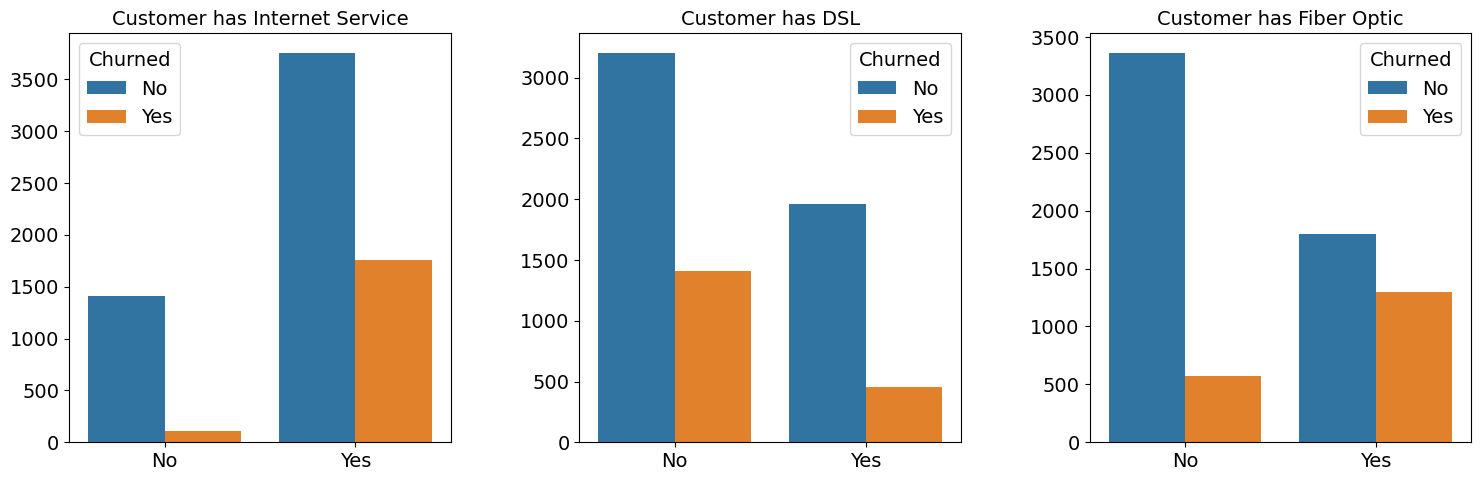

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16,6), dpi=100, facecolor='white')

sns.countplot(x='InternetService_yn', hue='Churn', data=df, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0].set_title('Customer has Internet Service', fontsize=14)

sns.countplot(x='DSL_yn', hue='Churn', data=df, ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)
ax[1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1].set_title('Customer has DSL', fontsize=14)

sns.countplot(x='Fiber_yn', hue='Churn', data=df, ax=ax[2])
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[2].set_title('Customer has Fiber Optic', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/internet_services.svg')
fig.show()

- Customers with Internet Service are more prone to churn
- Customers with fiber optic are, also, more likely to churn, in contrast with those with a DSL connection

##### *Plot other services*

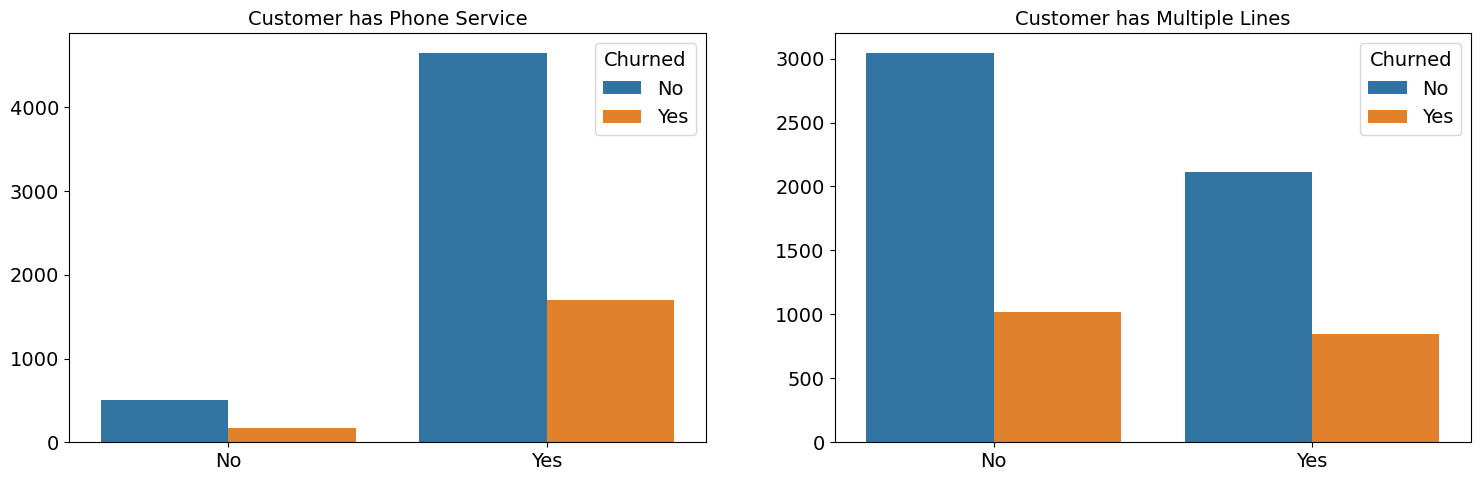

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=100)

sns.countplot(x='PhoneService', hue='Churn', data=df, ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0].set_title('Customer has Phone Service', fontsize=14)

sns.countplot(x=df['MultipleLines_yn'], hue='Churn', data=df, ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1].set_title('Customer has Multiple Lines', fontsize=14)

fig.tight_layout(pad=5)
fig.show()

- Phone service and multiple lines don't seem to affect whether a customer will churn

##### *Plot extra services*

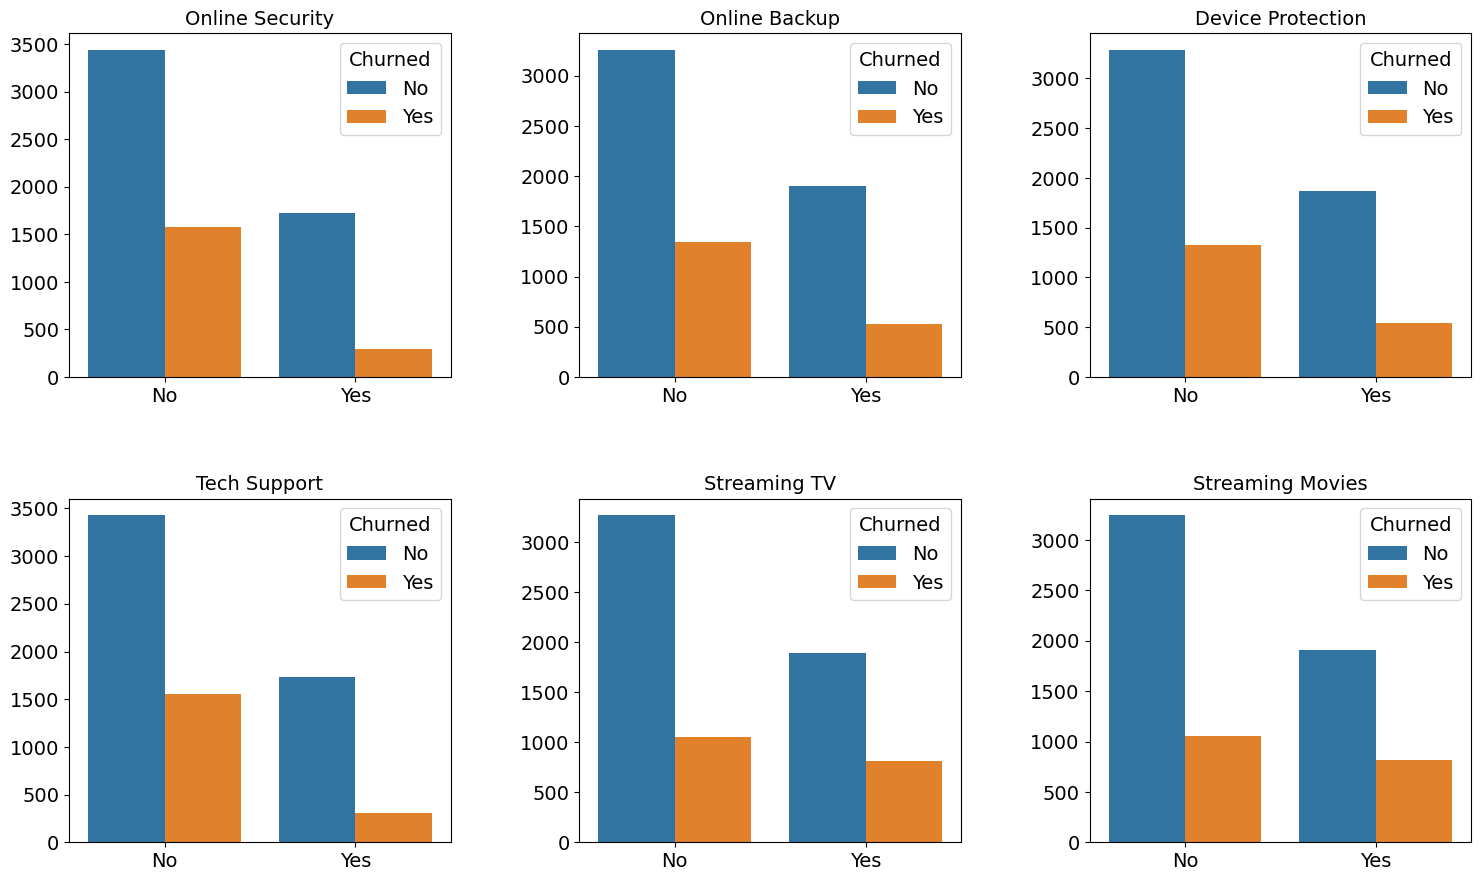

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(16,10), dpi=100)

sns.countplot(x='OnlineSecurity_yn', hue='Churn', data=df, ax=ax[0,0])
ax[0,0].set_xlabel(None)
ax[0,0].set_ylabel(None)
ax[0,0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,0].set_title('Online Security', fontsize=14)

sns.countplot(x='OnlineBackup_yn', hue='Churn', data=df, ax=ax[0,1])
ax[0,1].set_xlabel(None)
ax[0,1].set_ylabel(None)
ax[0,1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0,1].tick_params(axis='both', which='major', labelsize=14)
ax[0,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,1].set_title('Online Backup', fontsize=14)

sns.countplot(x='DeviceProtection_yn', hue='Churn', data=df, ax=ax[0,2])
ax[0,2].set_xlabel(None)
ax[0,2].set_ylabel(None)
ax[0,2].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[0,2].tick_params(axis='both', which='major', labelsize=14)
ax[0,2].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[0,2].set_title('Device Protection', fontsize=14)

sns.countplot(x='TechSupport_yn', hue='Churn', data=df, ax=ax[1,0])
ax[1,0].set_xlabel(None)
ax[1,0].set_ylabel(None)
ax[1,0].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,0].set_title('Tech Support', fontsize=14)

sns.countplot(x='StreamingTV_yn', hue='Churn', data=df, ax=ax[1,1])
ax[1,1].set_xlabel(None)
ax[1,1].set_ylabel(None)
ax[1,1].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,1].set_title('Streaming TV', fontsize=14)

sns.countplot(x='StreamingMovies_yn', hue='Churn', data=df, ax=ax[1,2])
ax[1,2].set_xlabel(None)
ax[1,2].set_ylabel(None)
ax[1,2].set_xticklabels(['No', 'Yes'], fontsize=14)
ax[1,2].tick_params(axis='both', which='major', labelsize=14)
ax[1,2].legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
ax[1,2].set_title('Streaming Movies', fontsize=14)

fig.tight_layout(pad=5)
fig.show()

- Customers without online security and/or tech support services are more likely to churn

##### *Plot contract types*

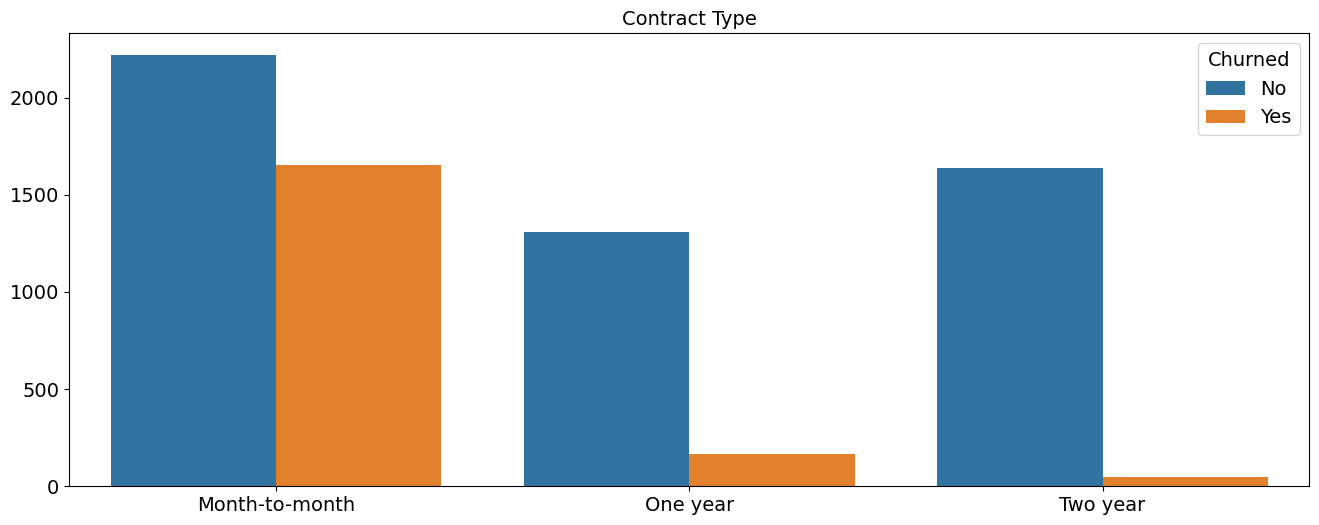

In [29]:
plt.figure(figsize=(16,6), dpi=100, facecolor='white')
sns.countplot(x='Contract', hue='Churn', data=df)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
plt.title('Contract Type', fontsize=14)
plt.savefig('./images/contract_types.svg')
plt.show()

- Customers with short-term contracts (monthly-to-month) are more likely to churn

##### *Plot number of customers based on tenure and contract type*

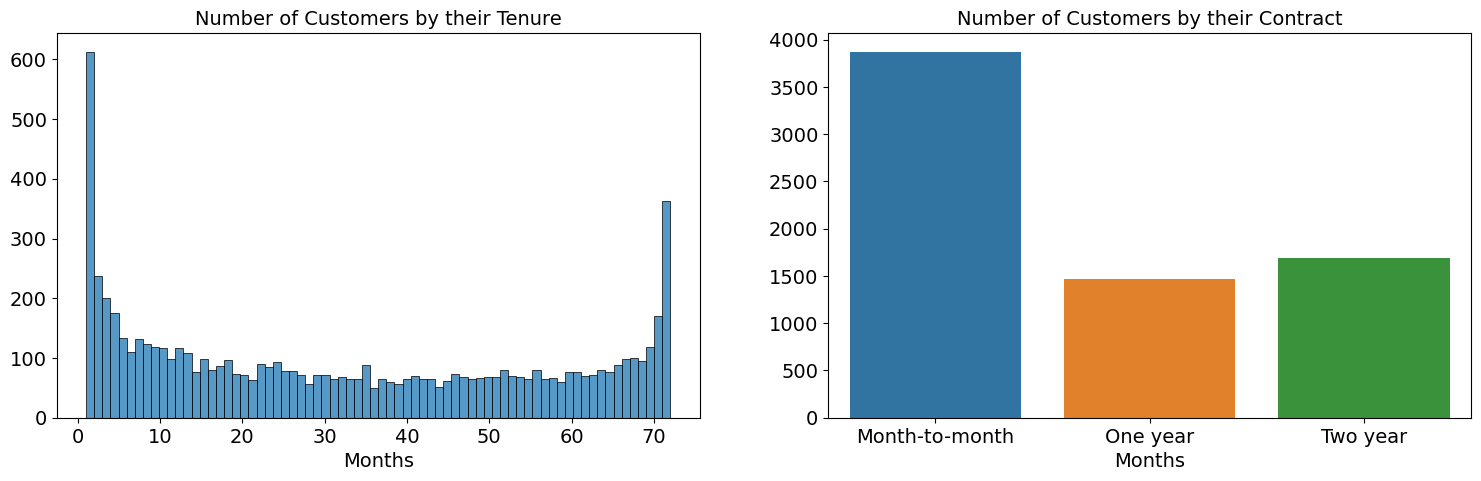

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=100, facecolor='white')

sns.histplot(df['tenure'], bins=df.tenure.max(), ax=ax[0])
ax[0].set_xlabel('Months', fontsize=14)
ax[0].set_ylabel(None)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Number of Customers by their Tenure', fontsize=14)

sns.countplot(x=df['Contract'], ax=ax[1])
ax[1].set_xlabel('Months', fontsize=14)
ax[1].set_ylabel(None)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('Number of Customers by their Contract', fontsize=14)

fig.tight_layout(pad=5)
fig.savefig('./images/no_customers_by_tenure_and_contract.svg')
fig.show()

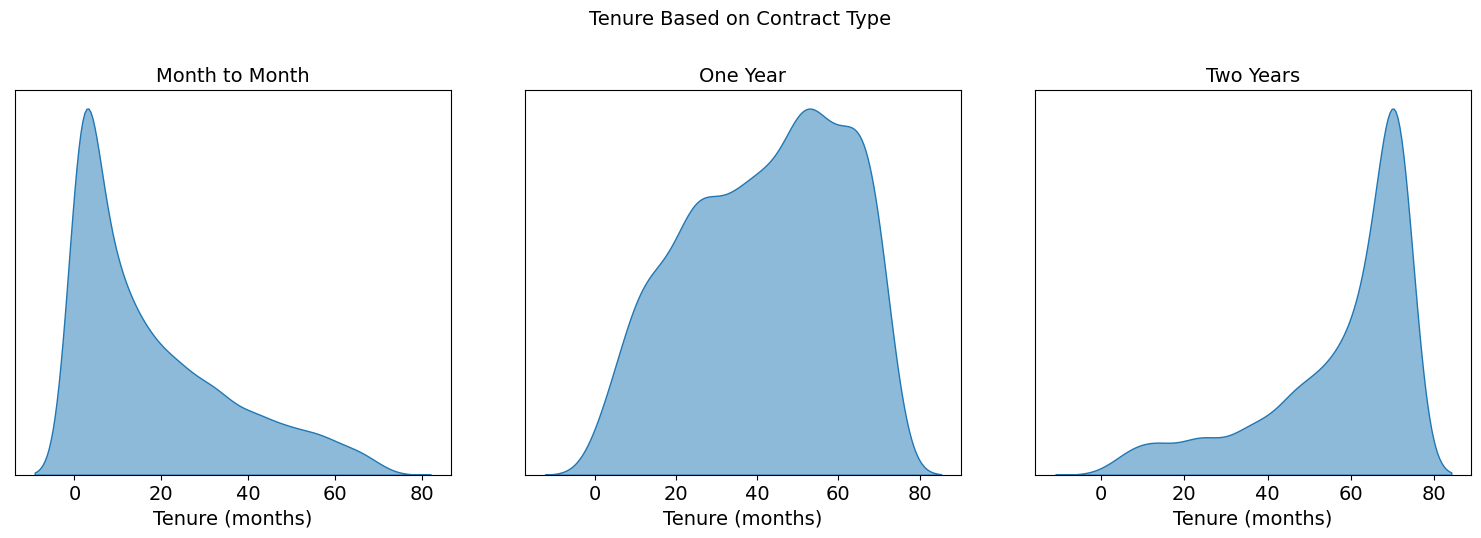

In [31]:
fig, ax = plt.subplots(1,3, figsize=(16,6), dpi=100, facecolor='white')

#sns.histplot(df[df['Contract']=='Month-to-month']['tenure'], bins=df.tenure.max(), ax=ax[0])
sns.kdeplot(df[df['Contract']=='Month-to-month']['tenure'], shade=True, alpha=0.5, label='No', ax=ax[0])
ax[0].set_xlabel('Tenure (months)', fontsize=14)
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Month to Month', fontsize=14)

#sns.histplot(df[df['Contract']=='One year']['tenure'], bins=df.tenure.max(), ax=ax[1])
sns.kdeplot(df[df['Contract']=='One year']['tenure'], shade=True, alpha=0.5, label='No', ax=ax[1])
ax[1].set_xlabel('Tenure (months)', fontsize=14)
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('One Year', fontsize=14)

#sns.histplot(df[df['Contract']=='Two year']['tenure'], bins=df.tenure.max(), ax=ax[2])
sns.kdeplot(df[df['Contract']=='Two year']['tenure'], shade=True, alpha=0.5, label='No', ax=ax[2])
ax[2].set_xlabel('Tenure (months)', fontsize=14)
ax[2].set_ylabel(None)
ax[2].set_yticks([])
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_title('Two Years', fontsize=14)

fig.tight_layout(pad=5)
fig.suptitle('Tenure Based on Contract Type', fontsize=14)
fig.savefig('./images/no_customers_by_tenure.svg')
fig.savefig('./images/no_customers_by_tenure.jpg')
fig.show()

- Most of the month-to-month contracts last very few months
- Most of the 2-year contracts last more than 5 years in total
- In general, customers with longer contracts seem to be more loyal

##### *Plot payment methods*

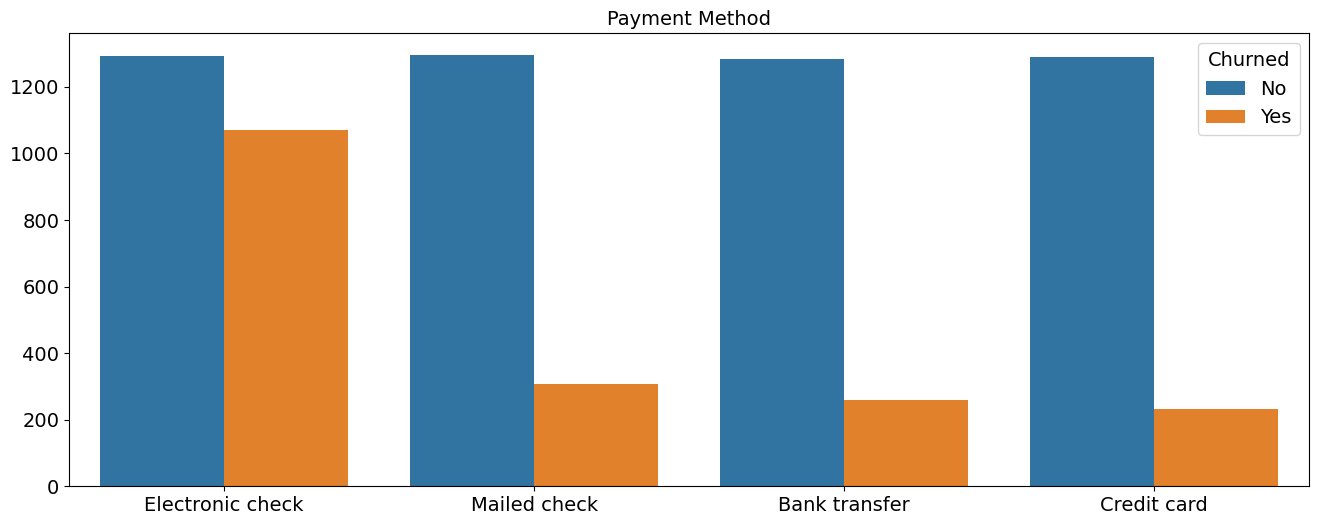

In [32]:
plt.figure(figsize=(16,6), dpi=100)
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Churned', labels=['No','Yes'], title_fontsize=14, fontsize=14)
plt.title('Payment Method', fontsize=14)
plt.show()

- According to the graph, the prefered payment method among customers is electronic check
- Also the customers who use electronic check are more likely to churn

**Key Findings**

- There is a great imbalance in the dataset which we need to take care of
- Approximately 1 out of 4 customers left the company within the last month
- Senior citizens and customers with dependents are more likely to churn
- Recent customers (smaller tenure) and customers with short-term contracts (monthly-to-month) are more likely to churn
- Customers with internet service, and especially fiber optic, are quite likely to churn
- Moreover, clients with higher monthly charges are prone to churn
- Even though electronic check is the preferred payment method, customers using electronic check are more likely to churn

## Data Preprocessing <a class='anchor' id='data_preprocessing'></a>

- First, we need to choose the columns with which we want to proceed

##### *Choose relevant columns*

In [33]:
# choose columns
cols = np.r_[1:7, 15:20, 21:32, 20]

# final df
df = df.iloc[:, cols]

In [34]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn,Churn
0,Female,0,Yes,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.850000,0,1,1,0,0,0,1,0,0,0,0,0
1,Male,0,No,No,34,Yes,One year,No,Mailed check,56.95,1889.500000,0,1,1,0,0,1,0,1,0,0,0,0
2,Male,0,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.150002,0,1,1,0,0,1,1,0,0,0,0,1
3,Male,0,No,No,45,No,One year,No,Bank transfer,42.30,1840.750000,1,1,1,0,0,1,0,1,1,0,0,0
4,Female,0,No,No,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.649994,0,1,0,1,0,0,0,0,0,0,0,1


### *One-Hot Encoding* <a class='anchor' id='ohe'></a>

In [35]:
# get dummy variables
df = pd.get_dummies(df, drop_first=False)

# columns
df.columns = df.columns.str.replace(' ', '_').str.replace('-','_')

In [36]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer,PaymentMethod_Credit_card,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.850000,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.500000,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.150002,0,1,1,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.750000,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.649994,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0


### *Train Test Split* <a class='anchor' id='train_test_split'></a>

In [37]:
# define x, y
x = df.drop(columns='Churn')
y = df.Churn

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

In [38]:
x_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,auto_PaymentMethod,InternetService_yn,DSL_yn,Fiber_yn,MultipleLines_yn,OnlineSecurity_yn,OnlineBackup_yn,DeviceProtection_yn,TechSupport_yn,StreamingTV_yn,StreamingMovies_yn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer,PaymentMethod_Credit_card,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
1038,0,56,80.90,4557.500000,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0
1016,0,71,80.10,5585.399902,0,1,1,0,1,1,1,1,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1
3255,1,66,110.60,7210.850098,1,1,0,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0
6381,0,1,19.55,19.549999,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1
6296,1,31,50.40,1580.099976,1,1,1,0,0,1,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0


## Feature Engineering <a class='anchor' id='feature_engineering'></a>

### *Feature Transformation* <a class='anchor' id='feature_transformation'></a>

- Feature transformation is a mathematical transformation in which we apply a mathematical formula to a particular column
- In our case, we will transform the values of the `TotalCharges` column using box-cox
- The reason is that its values have currently a very high variance which will affect our analysis and predictions

##### *Check current `TotalCharges` distribution in `x_train` and `x_test`*

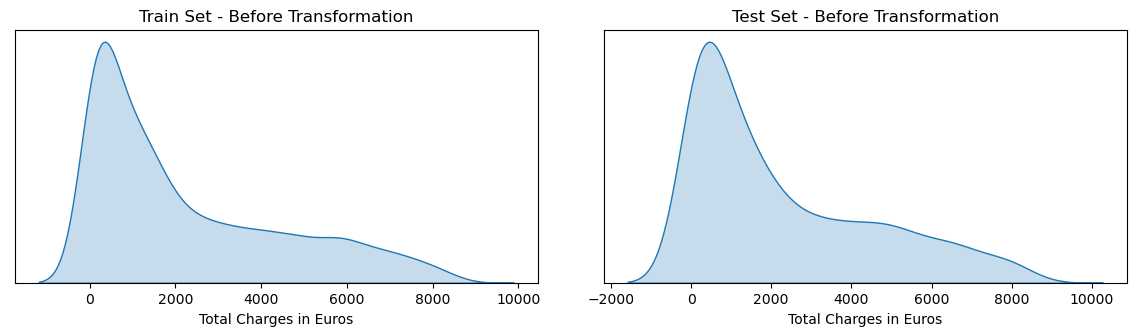

In [39]:
# create figure
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=100)
    
# plot histogram
sns.kdeplot(x_train.TotalCharges, shade=True, ax=ax[0])
ax[0].set_xlabel('Total Charges in Euros')
ax[0].set_ylabel(None)   
ax[0].set_yticks([])
ax[0].set_title('Train Set - Before Transformation')

sns.kdeplot(x_test.TotalCharges, shade=True, ax=ax[1])
ax[1].set_xlabel('Total Charges in Euros')
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].set_title('Test Set - Before Transformation')

fig.tight_layout(pad=3)
fig.show()

##### *Transform `TotalCharges` in `x_train` and `x_test`*

In [40]:
# feature to transform
to_transform = 'TotalCharges'

# transform using box-cox
x_train[to_transform], best_lambda = boxcox(x_train[to_transform], lmbda=None)
x_test[to_transform] = boxcox(x_test[to_transform], lmbda=best_lambda)

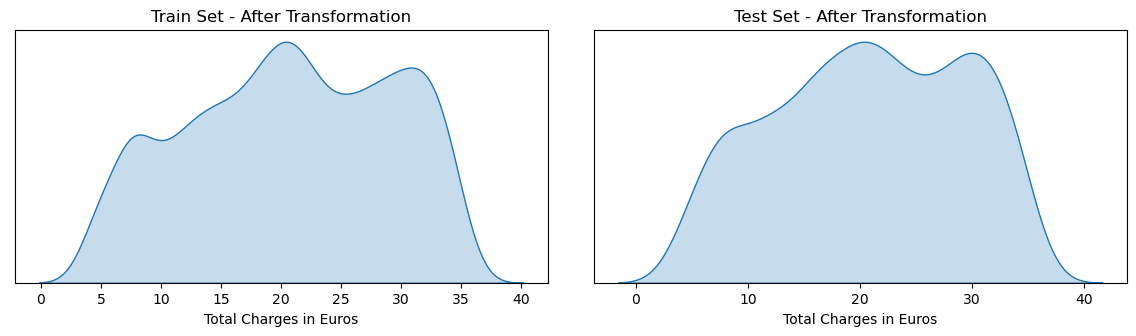

In [41]:
# create figure
fig, ax = plt.subplots(1, 2, figsize=(12,4), dpi=100)
    
# plot histogram
sns.kdeplot(x_train.TotalCharges, shade=True, ax=ax[0])
ax[0].set_xlabel('Total Charges in Euros')
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].set_title('Train Set - After Transformation')

sns.kdeplot(x_test.TotalCharges, shade=True,ax=ax[1])
ax[1].set_xlabel('Total Charges in Euros')
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].set_title('Test Set - After Transformation')

fig.tight_layout(pad=3)
fig.show()

### *Feature Scaling* <a class='anchor' id='feature_scaling'></a>

- Some machine learning algorithms will not work properly if the range of values of the data varies widely
- *Feature Scaling* is a method used to normalize the range of independent variables of the data
- Most of the features in our dataset are already normalized, but for those that are not we need to apply scaling

##### *Get the features that need to be scaled*

In [42]:
# get the features that need scaling
to_scale = [feature for feature in x_train.columns if (df[feature].max() > 1)]

# features to scale
print(f'Features to scale: {to_scale}')

Features to scale: ['tenure', 'MonthlyCharges', 'TotalCharges']


- Now that we have obtained the features, we need to decide what technique we should use to scale them
- In order to have a better understanding on that, let's have a look at their distributions
- Depending whether or not they follow a normal distribution, we will choose the appropriate scaler

##### *Create a function to visualize the distribution of non-normalized features*

In [43]:
def plot_distribution(df, i, feature):
    """
    1. Calculate feature skewness
    2. Run Shapiro Wilk test on a sample to test normality hypothesis
    3. Plot feature distribution
    """
    
    # calculate skewnees
    skewness = df[feature].skew()
    
    # select a sample of 1000 data points
    sample = df[feature].sample(n=1000, random_state=1)
    # test for normal distribution
    shapiro_wilk = shapiro(sample)
    norm_distrib = ('True' if shapiro_wilk.pvalue > 0.05 else 'False')
    
    # print results
    print(f'# {i+1} - {feature}')
    print('='*117)
    print(f'Skewness: {skewness}')
    print('-'*117)
    print(f'Shapiro Wilk test: {shapiro_wilk}')
    print('-'*117)
    print(f'Normal Distribution: {norm_distrib}')
    print('='*117)
    
    # create figure
    plt.figure(figsize=(16,6), dpi=100)
    
    # plot histogram
    sns.kdeplot(df[feature], shade=True)
    
    # params
    plt.xlabel(None)
    plt.ylabel(None)
    plt.yticks([])
    plt.title(f'{feature} distribution', fontsize=14)
    
    plt.tight_layout(pad=3)
    plt.show()
    
    return None

##### *Shapiro-Wilk Normality Test*

- We will use Shapiro-Wilk test to detect if the population of the features that are being tested is normally distributed

*Hypothesis Testing*
- **Null Hypothesis (H0):** The sample (obtained from `feature_name`) comes from a normal distribution
- **Alternative Hypothesis (H1):** The sample (obtained from `feature_name`) does not come from a normal distribution

*Results*
- We **reject** the Null Hypothesis (H0) if p-value < 0.05

# 1 - tenure
Skewness: 0.24140026684019025
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.8960144519805908, pvalue=1.8921790235954206e-25)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


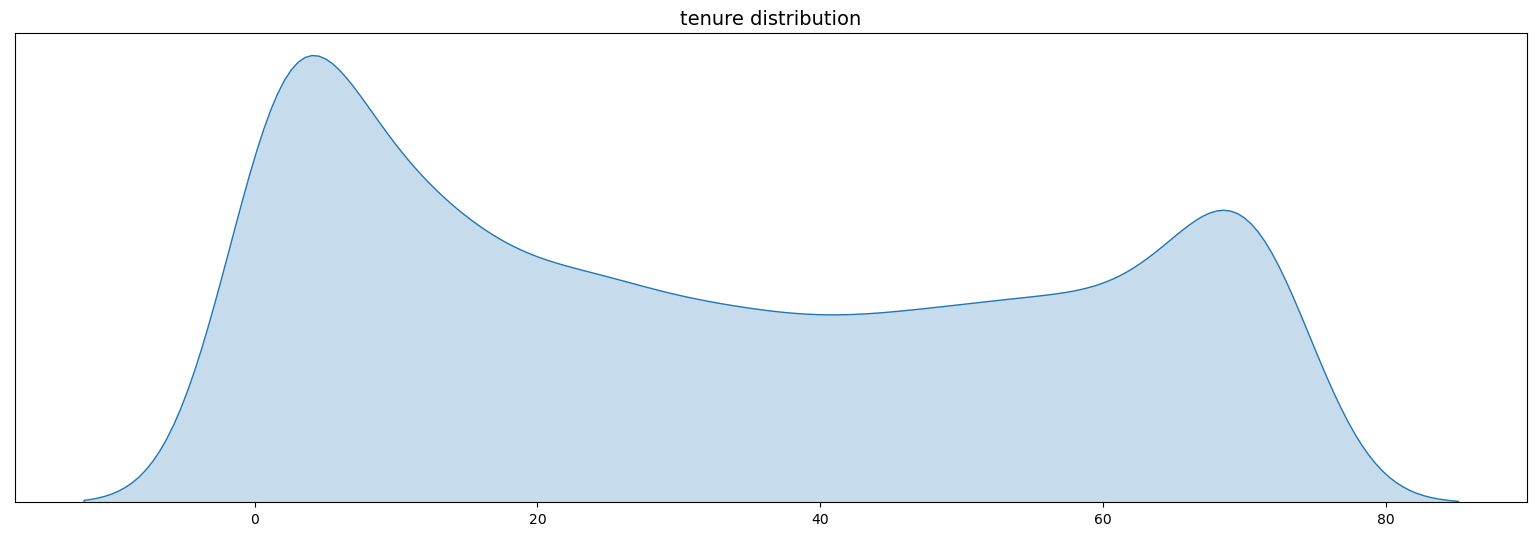

# 2 - MonthlyCharges
Skewness: -0.22500832854581657
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9249390363693237, pvalue=6.334159269560838e-22)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


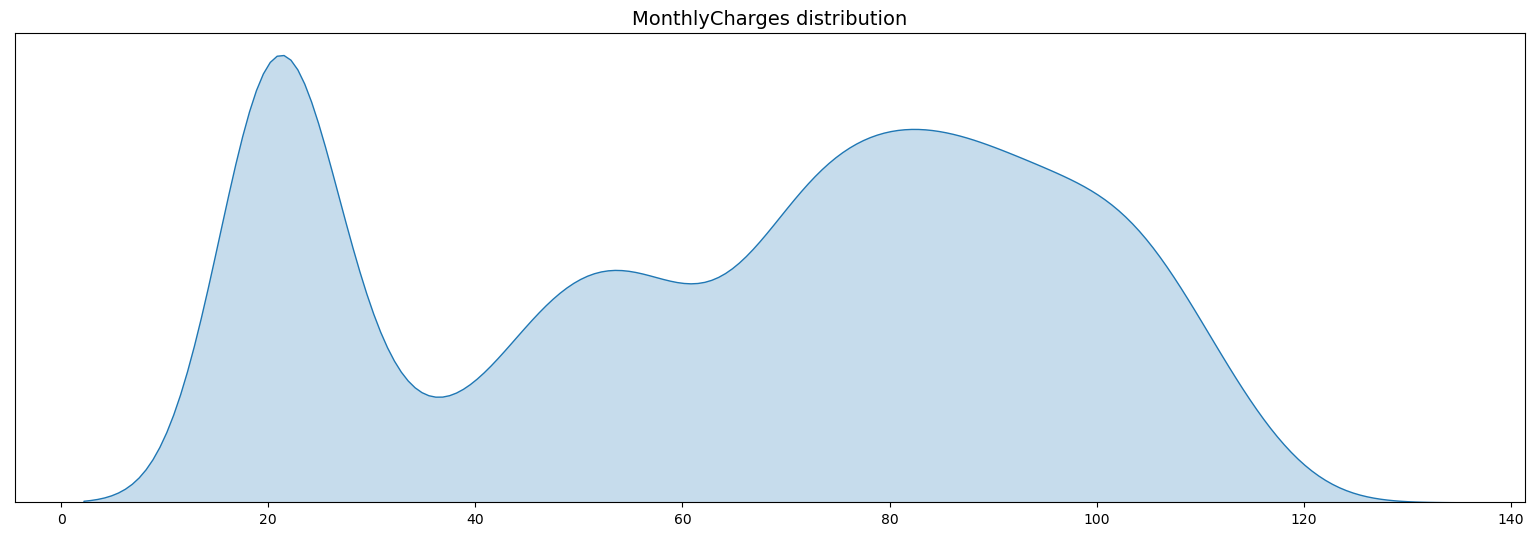

# 3 - TotalCharges
Skewness: -0.1457083523273468
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9625574350357056, pvalue=2.4373629284709037e-15)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


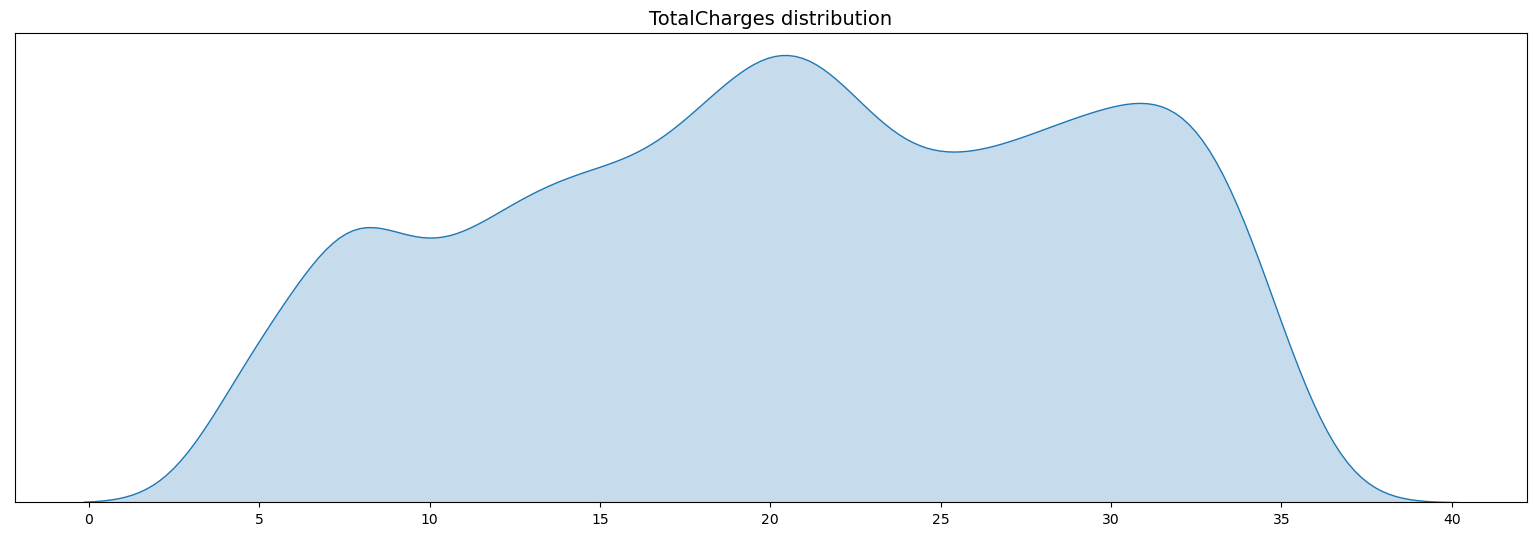

In [44]:
_ = [plot_distribution(x_train, i, feature) for i, feature in enumerate(to_scale)]

- According to the graphs, none of the features seems to follow a normal distribution
- Moreover, the *p-value* obtained from the Shapiro-Wilk test is less than 5%, indicating that none of the samples tested comes from a normal distribution
- Therefore, we **reject** the null hypothesis
- As a result of the previous test, we will scale these features using `MinMaxScaler`

##### *Scale using `MinMaxScaler`*

In [45]:
# initialise scaler
mms = MinMaxScaler()

# scale train and test data
x_train[to_scale] = mms.fit_transform(x_train[to_scale])
x_test[to_scale] = mms.transform(x_test[to_scale])

### *Handle Class Imbalance* <a class='anchor' id='handle_class_imbalance'></a>

In [46]:
y_train.value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

- We knew that our dataset is highly imbalanced
- In order to handle that, we will cluster the abundant class

***Methodology***

- Let N be the number of samples in the rare class
- We will cluster the abundant class into N clusters
- Then, we will find the centroids of each cluster and use them as the training data for the abundant class
- By doing so, the classes will be balanced
- Furthermore, by using the centroids, the training data for the abundant class will be more representative
- On the other hand, though, the dataset will be smaller

##### *Cluster the abundant class*

In [47]:
xb_train, yb_train, _ = cluster_the_majority_class_and_keep_only_the_centroids(x_train, y_train)

In [48]:
yb_train.value_counts()

1    1495
0    1495
dtype: int64

##### *Visualize the change into the 2 dimensions*

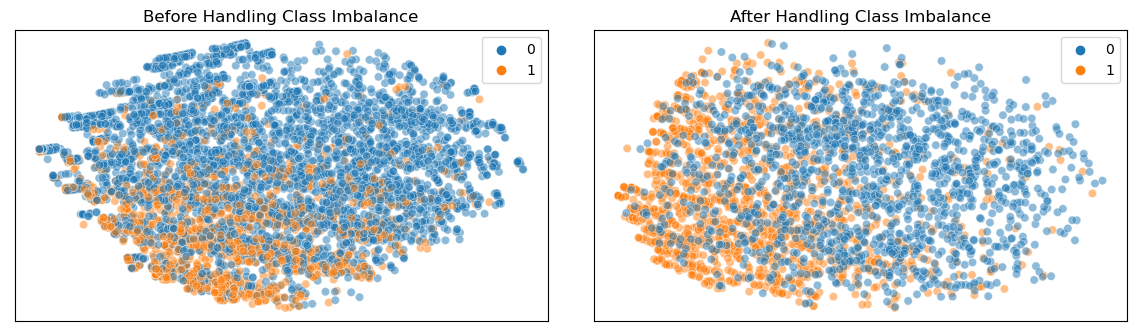

In [49]:
# create a pca instance
pca = PCA(n_components=2)

# project data
# both before and after class imbalance
# into the 2 dimensions
x_before = pca.fit_transform(x_train)
x_after = pca.fit_transform(xb_train)

# plot data
fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=100, facecolor='white')
sns.scatterplot(x=x_before[:,0], y=x_before[:,1], hue=y_train.values, sizes=[10,50], alpha=0.5, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Before Handling Class Imbalance')

sns.scatterplot(x=x_after[:,0], y=x_after[:,1], hue=yb_train.values, sizes=[10,50], alpha=0.5, ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('After Handling Class Imbalance')

fig.tight_layout(pad=3)
fig.savefig('./images/class_imbalance_prior_post_pca.svg')
fig.show()

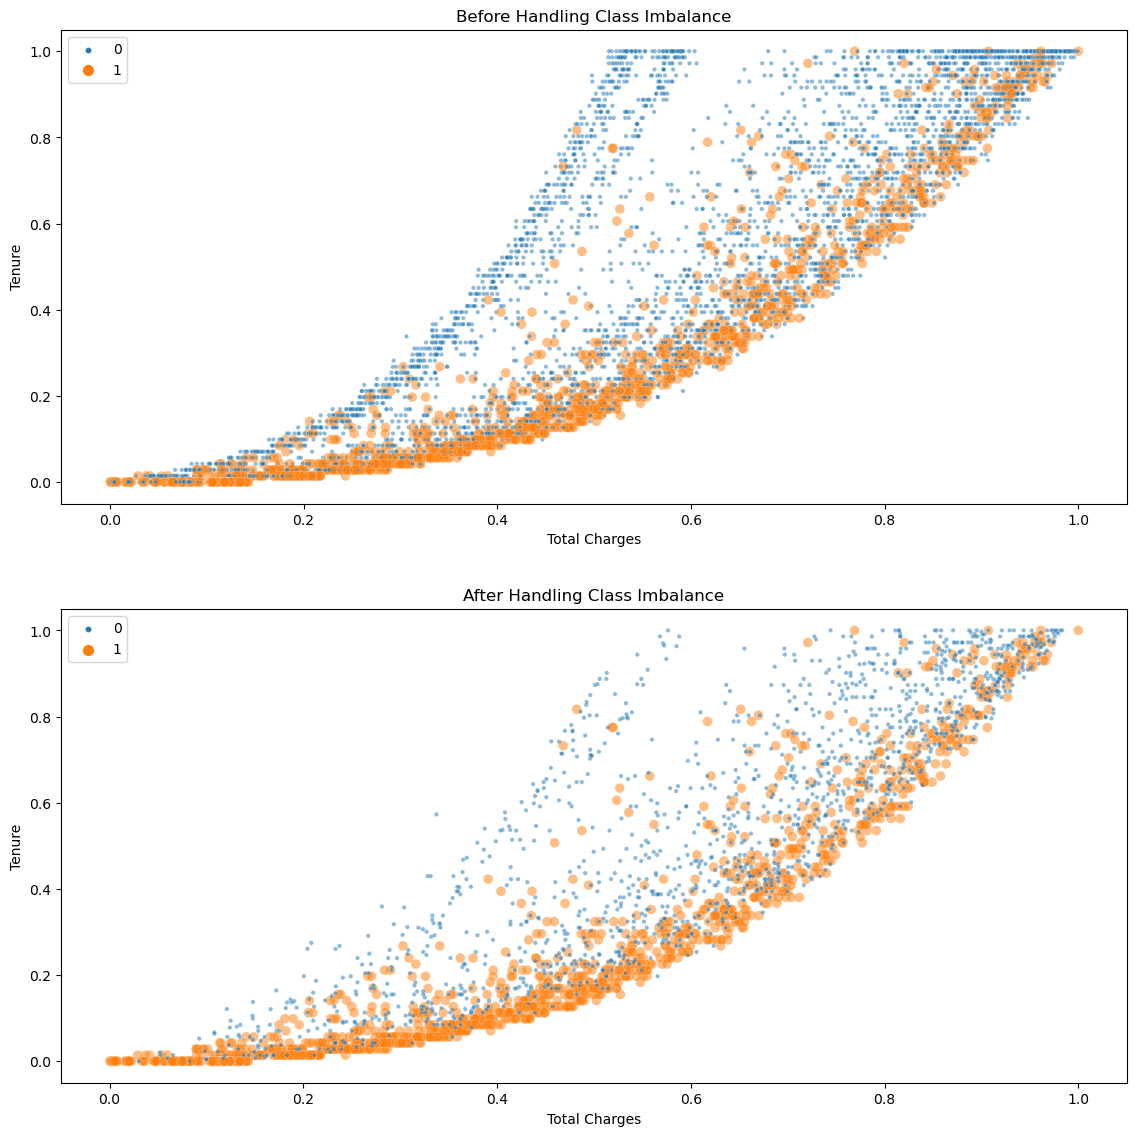

In [50]:
fig, ax = plt.subplots(2,1,figsize=(12,12), dpi=100, facecolor='white')

sns.scatterplot(x=x_train.TotalCharges, y=x_train.tenure, hue=y_train.values, size=y_train.values, sizes=[10,50], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Total Charges')
ax[0].set_ylabel('Tenure')
ax[0].set_title('Before Handling Class Imbalance')

sns.scatterplot(x=xb_train.TotalCharges, y=xb_train.tenure, hue=yb_train.values, size=yb_train.values, sizes=[10,50], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Total Charges')
ax[1].set_ylabel('Tenure')
ax[1].set_title('After Handling Class Imbalance')

fig.tight_layout(pad=3)
fig.savefig('./images/class_imbalance_prior_post_clusters.svg')
fig.show()

## Modeling <a class='anchor' id='modeling'></a>

### *Cross Validation* <a class='anchor' id='cross_validation'></a>

##### *Create a list of classifiers to try*

In [51]:
# list of classifiers
models = [['LogisticRegression', LogisticRegression(random_state=1)],
          ['SVC', SVC(random_state=1)],
          ['KNN', KNeighborsClassifier()],
          ['RandomForest', RandomForestClassifier(random_state=1)],
          ['LightGBM', LGBMClassifier(random_state=1)]]

##### *Cross validate the classifiers*

In [52]:
# set starting time
start_time = datetime.now()

# execute custom cross validation function
cv_scores = cross_validate_models(xb_train, yb_train, models)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

Running time: 0:00:03.816372


In [53]:
# print results
print(cv_scores.sort_values(by='F1 Score', ascending=False))

                    Precision    Recall  F1 Score       AUC  Accuracy
LightGBM             0.873892  0.894314  0.883967  0.953591  0.882609
RandomForest         0.832754  0.842140  0.837359  0.915915  0.836455
SVC                  0.772467  0.830100  0.800048  0.885198  0.792642
LogisticRegression   0.764842  0.797993  0.780831  0.860252  0.776254
KNN                  0.696495  0.775920  0.733898  0.759640  0.719064


### *GridSearchCV* <a class='anchor' id='grid_search_cv'></a>

##### *Create a hyperparameters grid to fine-tune the classifiers*

In [54]:
# list of hyperparameters
param_grid = [['LogisticRegression', {'penalty': ['l1','l2','elasticnet'],
                                      'C': np.arange(0.1,0.4,0.1), # [10**(-i) for i in range(5)]
                                      'solver': ['lbfgs','liblinear','saga'],
                                      'max_iter': range(100,600,100)}],
              ['SVC', {'C': [10**(-i) for i in range(5)],
                       'kernel': ['linear','poly','rbf','sigmoid']}],
              ['KNN', {'n_neighbors': range(5,55,5),
                       'weights': ['uniform','distance'], 'p': [1,2]}],
              ['RandomForest', {'n_estimators': range(100,600,100),
                                'criterion': ['gini','entropy','log_loss'],
                                'bootstrap': [True,False]}],
              ['LightGBM', {'num_iterations': range(100,600,100),
                            'learning_rate': np.arange(0.1,0.4,0.1), # [10**(-i) for i in range(5)]
                            'subsample': np.arange(0.6,1,0.1),
                            'subsample_freq': range(10,50,10),
                            'colsample_bytree': np.arange(0.4,1,0.1)}]]

##### *Fine-tune the classifiers*

In [55]:
# set starting time
start_time = datetime.now()

# execute custom grid search function
gs_scores = grid_search_tune_models(xb_train, yb_train, models, param_grid, scoring='f1')

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

1. LogisticRegression
---------------------------------------------------------------------------------------------------------------------
Best grid score: 0.7877320669970481
Best grid params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best estimator: LogisticRegression(C=0.1, penalty='l1', random_state=1, solver='saga')

2. SVC
---------------------------------------------------------------------------------------------------------------------
Best grid score: 0.8000475416352992
Best grid params: {'C': 1, 'kernel': 'rbf'}
Best estimator: SVC(C=1, random_state=1)

3. KNN
---------------------------------------------------------------------------------------------------------------------
Best grid score: 0.789201875245438
Best grid params: {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=30, p=1)

4. RandomForest
---------------------------------------------------------------------------------------------------------

### *Predictions (on test set)* <a class='anchor' id='predictions'></a>

##### *Create a list with the tuned classifiers*

In [56]:
# list of tuned classifiers
hp_models = [['LogisticRegression', LogisticRegression(C=0.1, penalty='l1', solver='saga', random_state=1)],
             ['SVC', SVC(C=1, random_state=1)],
             ['KNN', KNeighborsClassifier(n_neighbors=30, p=1)],
             ['RandomForest', RandomForestClassifier(bootstrap=False, criterion='entropy', n_estimators=500, random_state=1)],
             ['LightGBM', LGBMClassifier(colsample_bytree=0.4, subsample=0.8, subsample_freq=10, num_iterations=200, random_state=1)]]

##### *Make predictions*

In [57]:
# set starting time
start_time = datetime.now()

# execute custom function to make predictions
predictions = make_predictions(xb_train, x_test, yb_train, y_test, hp_models)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

1. LogisticRegression
---------------------------------------------------------------------------------------------------------------------
 True Positives: 299
 True Negatives: 741
False Positives: 292
False Negatives: 75
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407

2. SVC
---------------------------------------------------------------------------------------------------------------------
 True Positives: 306
 True Negatives: 689
False Positives: 344
False Negatives: 68
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1033
           1       0.47  

In [58]:
# print results
print(predictions.sort_values(by='F1 Score', ascending=False))

                    Precision    Recall  F1 Score       AUC  Accuracy
LogisticRegression   0.505922  0.799465  0.619689  0.758397  0.739161
SVC                  0.470769  0.818182  0.597656  0.742586  0.707178
RandomForest         0.452276  0.823529  0.583886  0.731223  0.687989
KNN                  0.438451  0.847594  0.577940  0.727282  0.670931
LightGBM             0.424359  0.885027  0.573657  0.725185  0.650320


### *Feature Importance* <a class='anchor' id='feature_importance'></a>

##### *Get the top 10 features as decided by Logistic Regression*

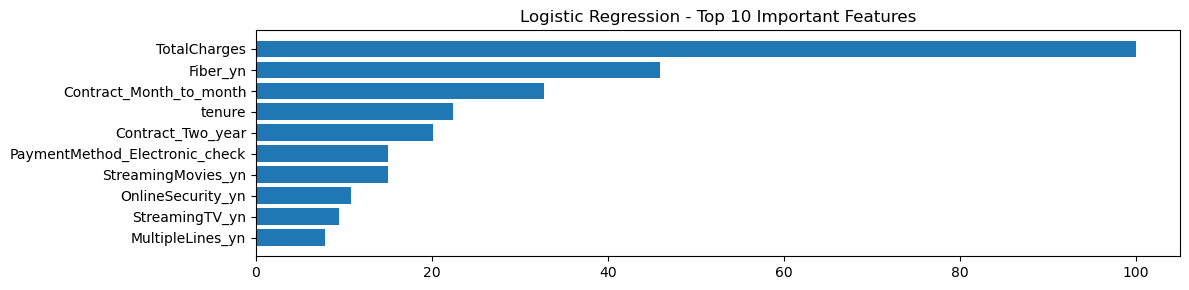

In [59]:
# define logistic regression model
clf = LogisticRegression(C=0.1, penalty='l1', solver='saga', random_state=1)

# train the model
clf.fit(xb_train, yb_train)

# get feature importance
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# get the indices of the top 10 features
sorted_idx = np.argsort(feature_importance)[-10::]
position = np.arange(sorted_idx.shape[0]) + .5

# plot feature importance
plt.figure(figsize=(12,3), dpi=100, facecolor='white')
plt.barh(position, feature_importance[sorted_idx], align='center')
plt.yticks(position, labels=np.array(xb_train.columns)[sorted_idx])
# plt.yticks(pos, labels=[])
plt.title('Logistic Regression - Top 10 Important Features')
plt.tight_layout()
plt.savefig('./images/feature_importance_logistic_regression.svg')
plt.savefig('./images/feature_importance_logistic_regression.jpg')
plt.show()

##### *Get the top 10 features as decided by LightGBM*

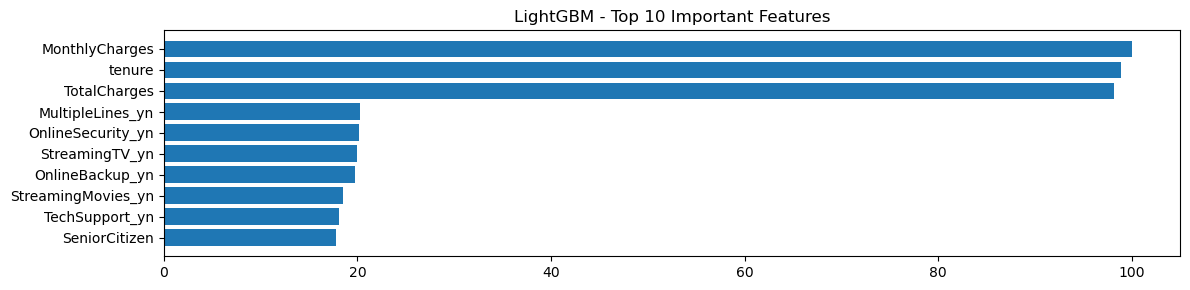

In [60]:
# define lightgbm model
clf = LGBMClassifier(colsample_bytree=0.4, subsample=0.8, subsample_freq=10, num_iterations=200, random_state=1)

# train the model
clf.fit(xb_train, yb_train)

# get feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# get the indices of the top 10 features
sorted_idx = np.argsort(feature_importance)[-10::]
position = np.arange(sorted_idx.shape[0]) + .5

# plot feature importance
plt.figure(figsize=(12,3), dpi=100, facecolor='white')
plt.barh(position, feature_importance[sorted_idx], align='center')
plt.yticks(position, labels=np.array(xb_train.columns)[sorted_idx])
# plt.yticks(pos, labels=[])
plt.title('LightGBM - Top 10 Important Features')
plt.tight_layout()
plt.savefig('./images/feature_importance_lightgbm.svg')
plt.savefig('./images/feature_importance_lightgbm.jpg')
plt.show()

---

*Thank you!*

---